<a href="https://colab.research.google.com/github/naufalbaihaqiz/Analisis-Sentimen-Bubarkan-DPR/blob/main/AnalisisSentimenBubarkanDPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#1. Import Package and Data


In [4]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.4 MB/s eta 0:00:00


In [5]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

import nltk
nltk.download('punkt')

import wordcloud
from wordcloud import WordCloud, STOPWORDS

from transformers import pipeline

import Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

import plotly.graph_objects as go


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
df = pd.read_csv('/content/drive/MyDrive/Dataset CSV/dataBubarkanDPR.csv', index_col=0)

In [7]:
df.head()

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1960504535375393102,Thu Aug 28 13:45:38 +0000 2025,0,@txtdrimedia PERCAYA...???? OHOOIII... DIMEDIA...,1961062620901118413,NaN,txtdrimedia,in,NaN,0,0,0,https://x.com/undefined/status/196106262090111...,1897985755676655618,NaN
1,1961020949446132062,Thu Aug 28 13:45:10 +0000 2025,0,@tempodotco DPR = Perwakilan PARTAI Mereka han...,1961062504550809912,NaN,tempodotco,in,NaN,0,0,0,https://x.com/undefined/status/196106250455080...,1668862741212442624,NaN
2,1961061955881390320,Thu Aug 28 13:42:59 +0000 2025,0,slot gacor hari ini Rabu apel pagi !!! BEM SI ...,1961061955881390320,https://pbs.twimg.com/tweet_video_thumb/GzcWi_...,NaN,in,NaN,0,0,0,https://x.com/undefined/status/196106195588139...,265380354,NaN
3,1961059548997021781,Thu Aug 28 13:33:25 +0000 2025,0,TETAP BERKELOMPOK usahakan pengawas disekitar ...,1961059548997021781,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/196105954899702...,1539290283757940736,NaN
4,1960902612779458595,Thu Aug 28 13:31:42 +0000 2025,0,@MasBRO_back BUBARKAN @DPR_RI paling tolol sed...,1961059117042118879,NaN,MasBRO_back,in,NaN,0,0,0,https://x.com/undefined/status/196105911704211...,460258217,NaN


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2028 entries, 0 to 2027
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   conversation_id_str      2028 non-null   int64  
 1   created_at               2028 non-null   object 
 2   favorite_count           2028 non-null   int64  
 3   full_text                2028 non-null   object 
 4   id_str                   2028 non-null   int64  
 5   image_url                250 non-null    object 
 6   in_reply_to_screen_name  1116 non-null   object 
 7   lang                     2028 non-null   object 
 8   location                 0 non-null      float64
 9   quote_count              2028 non-null   int64  
 10  reply_count              2028 non-null   int64  
 11  retweet_count            2028 non-null   int64  
 12  tweet_url                2028 non-null   object 
 13  user_id_str              2028 non-null   int64  
 14  username                 0 no

# 2. Cleaning Data

In [9]:
df = df[['created_at','full_text']]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2028 entries, 0 to 2027
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   created_at  2028 non-null   object
 1   full_text   2028 non-null   object
dtypes: object(2)
memory usage: 112.1+ KB


In [11]:
df['full_text'] = df['full_text'].astype(str).str.lower()
df['full_text'] = df['full_text'].replace('false', pd.NA)
df = df.dropna(subset=['full_text'])


In [12]:
df = df.drop_duplicates(subset=['full_text'])


In [13]:
def clean_twitter_text(text):
    # Hapus mention (contoh: @username)
    text = re.sub(r'@[A-Za-z0-9_]+', ' ', text)
    # Hapus hashtag (#)
    text = re.sub(r'#\w+', ' ', text)
    # Hapus RT (retweet)
    text = re.sub(r'\bRT\b', ' ', text)
    # Hapus URL (http atau https)
    text = re.sub(r'https?://\S+', ' ', text)
    # Hapus karakter non-alfanumerik
    text = re.sub(r'[^A-Za-z0-9 ]', ' ', text)
    # Hapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Terapkan fungsi pembersihan pada kolom full_text
df['full_text'] = df['full_text'].apply(clean_twitter_text)

In [14]:
df


,created_at,full_text
0,Thu Aug 28 13:45:38 +0000 2025,percaya ohooiii dimedia ngomong gitu aslinya t...
1,Thu Aug 28 13:45:10 +0000 2025,dpr perwakilan partai mereka hanya mewakili ke...
2,Thu Aug 28 13:42:59 +0000 2025,slot gacor hari ini rabu apel pagi bem si apel...
3,Thu Aug 28 13:33:25 +0000 2025,tetap berkelompok usahakan pengawas disekitar ...
4,Thu Aug 28 13:31:42 +0000 2025,bubarkan paling tolol sedunia
...,...,...
2023,Fri Aug 29 13:22:42 +0000 2025,coba pecat dulu itu kapolri dan dpr yg asbun i...
2024,Fri Aug 29 13:22:41 +0000 2025,sudah berapa hari demo ini ibu yth baru nongol...
2025,Fri Aug 29 13:22:40 +0000 2025,kebanyakan para anggota dpr belagu sih jumawa ...
2026,Fri Aug 29 13:22:39 +0000 2025,tai lah dialog2 udah bukan waktunya lagi dialo...


# 3. Preprocessing

## Normalisasi

In [15]:
# Normalisasi kata-kata gaul atau singkatan
norm = {
    'bnr ': 'benar', 'yg ': 'yang', 'thn ': 'tahun', 'wk ': ' ',
    'org ': 'orang', 'one ': 'satu', 'dg ': 'dengan', 'lali ': 'lupa',
    'bpk ': 'bapak', 'lg ': 'lagi', 'kyk ': 'kayak', 'mkan ': 'makan',
    'bljr ': 'belajar', 'tak ': 'tidak', 'dpt ': 'dapat', 'gt ': 'gitu',
    'rebu ': 'ribu', 'mikir2 ': 'mikir', 'siaaapp ': 'siap', 'okaaay ': 'oke',
    'udh ': 'sudah', 'ga ': 'tidak', 'gaskeun ': 'ayo', 'wowww ': 'wow',
    'haaa ': 'ha', 'oke ': 'oke', 'bener ': 'benar','gk ': 'tidak'
}

def normalisasi(text):
    for word, replacement in norm.items():
        text = text.replace(word, replacement)
    return text


# Terapkan normalisasi ke kolom full_text
df['full_text'] = df['full_text'].apply(lambda x: normalisasi(x))


In [16]:
df

,created_at,full_text
0,Thu Aug 28 13:45:38 +0000 2025,percaya ohooiii dimedia ngomong gitu aslinya t...
1,Thu Aug 28 13:45:10 +0000 2025,dpr perwakilan partai mereka hanya mewakili ke...
2,Thu Aug 28 13:42:59 +0000 2025,slot gacor hari ini rabu apel pagi bem si apel...
3,Thu Aug 28 13:33:25 +0000 2025,tetap berkelompok usahakan pengawas disekitar ...
4,Thu Aug 28 13:31:42 +0000 2025,bubarkan paling tolol sedunia
...,...,...
2023,Fri Aug 29 13:22:42 +0000 2025,coba pecat dulu itu kapolri dan dpr yangasbun ...
2024,Fri Aug 29 13:22:41 +0000 2025,sudah berapa hari demo ini ibu yth baru nongol...
2025,Fri Aug 29 13:22:40 +0000 2025,kebanyakan para anggota dpr belagu sih jumawa ...
2026,Fri Aug 29 13:22:39 +0000 2025,tai lah dialog2 udah bukan waktunya lagi dialo...


## Stopwords

In [17]:
import Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
more_stop_words = []

stop_words = StopWordRemoverFactory().get_stop_words()
stop_words.extend(more_stop_words)

new_array = ArrayDictionary(stop_words)
stop_words_remover_new = StopWordRemover(new_array)

def stopword(str_text):
    str_text = stop_words_remover_new.remove(str_text)
    return str_text

df['full_text'] = df['full_text'].apply(lambda x: stopword(x))
df.head()

,created_at,full_text
0,Thu Aug 28 13:45:38 +0000 2025,percaya ohooiii dimedia ngomong gitu aslinya t...
1,Thu Aug 28 13:45:10 +0000 2025,dpr perwakilan partai hanya mewakili kepenting...
2,Thu Aug 28 13:42:59 +0000 2025,slot gacor hari rabu apel pagi bem si apel pag...
3,Thu Aug 28 13:33:25 +0000 2025,tetap berkelompok usahakan pengawas disekitar ...
4,Thu Aug 28 13:31:42 +0000 2025,bubarkan paling tolol sedunia


## Tokenize

In [18]:
# Tokenize
tokenized = df['full_text'].apply(lambda x: x.split())
tokenized.head()


,full_text
0,"[percaya, ohooiii, dimedia, ngomong, gitu, asl..."
1,"[dpr, perwakilan, partai, hanya, mewakili, kep..."
2,"[slot, gacor, hari, rabu, apel, pagi, bem, si,..."
3,"[tetap, berkelompok, usahakan, pengawas, disek..."
4,"[bubarkan, paling, tolol, sedunia]"


## Stemming

In [ ]:
# Stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def stemming(text_cleaning):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    do = []
    for w in text_cleaning:
        dt = stemmer.stem(w)
        do.append(dt)
    d_clean = []
    d_clean = " ".join(do)
    print(d_clean)
    return d_clean

tokenized = tokenized.apply(stemming)
tokenized.to_csv(
    '/content/drive/MyDrive/Dataset CSV/hasilStemming.csv',
    index=False
)


percaya ohooiii media ngomong gitu asli tetap jalan bubar dpr selamat uang rakyat
dpr wakil partai hanya wakil penting partai dgn kamuflase penting rakyat tdk punya empati rakyat dpr hanya kumpul orang2 partai yangsaling bahu bahu bahkan saling sikut utk penting partai bubar dpr rakyat tdk butuh
slot gacor hari rabu apel pagi bem si apel pagi hari senin desak bubar dpr rakyat demo dapat adil adil adil ulang tragedi 98 langsung cobain situs gacor adil slot gacor
tetap kelompok usaha awas sekitar tetap ati ati waspada yangpaksa ambil paksa jutidakambil makanya kelompok masa banyak trus desak cabut cipta karya bubar dpr sahkan ampas aset
bubar paling tolol dunia
bubar dpr
nah makin lihat jelas pikir pikir bagus ke arah baik semotidaknarasi narasi konkret ini bawa para demo sehingtidaktuntutannya jelas ada roadmap jelas utk baik kalau cuma slogan singkat bubar dpr semua jg bilang
bubar dpr penjara semua yangada dalam buang laut kidul
iya bang prabowo mlm hrs buat statement bubar dpr ini po

#4. Labeling

In [20]:
df = pd.read_csv('/content/drive/MyDrive/Dataset CSV/hasilStemming.csv') # pake data hasil stemming
df

,full_text
0,percaya ohooiii media ngomong gitu asli tetap ...
1,dpr wakil partai hanya wakil penting partai dg...
2,slot gacor hari rabu apel pagi bem si apel pag...
3,tetap kelompok usaha awas sekitar tetap ati at...
4,bubar paling tolol dunia
...,...
1984,coba pecat dulu kapolri dpr yangasbun kalau aj...
1985,berapa hari demo ibu yth baru nongol ada korba...
1986,banyak anggota dpr belagu sih jumawa asa diri ...
1987,tai lah dialog2 udah bukan waktu dialog jabat ...


In [21]:
# Load sentiment classifier
classifier = pipeline("sentiment-analysis", model="w11wo/indonesian-roberta-base-sentiment-classifier")

# Fungsi prediksi sentimen
def prediksi_sentimen(teks):
    hasil = classifier(teks)
    # hasil berupa list dict: [{'label': 'POS', 'score': 0.99}]
    return hasil[0]['label']

# Terapkan ke kolom cleaned_text (ini akan butuh waktu karena 11k data)
df['sentimen'] = df['full_text'].apply(prediksi_sentimen)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


In [22]:
sentiment_count = df.sentimen.value_counts()
sentiment_count

,count
sentimen,
negative,1128
neutral,777
positive,84


/tmp/ipython-input-1891154076.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentimen', data=df, palette='Set1')


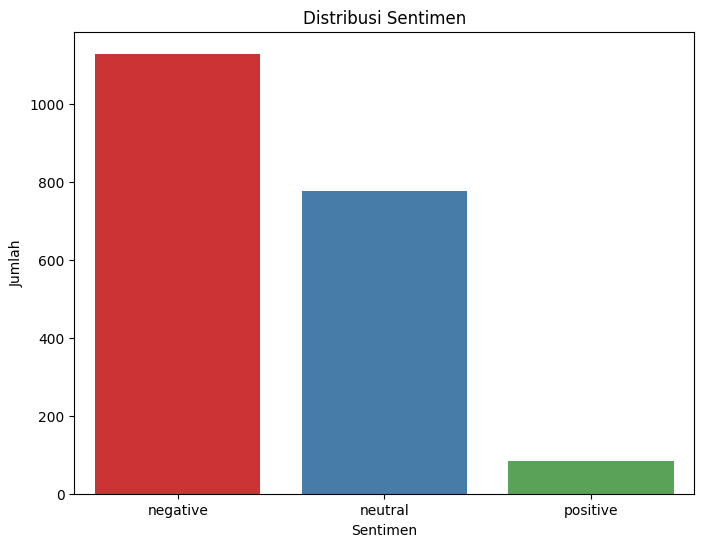

In [23]:
plt.figure(figsize=(8, 6))
sns.countplot(x='sentimen', data=df, palette='Set1')
plt.title('Distribusi Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

#5. Training Data

In [ ]:
x = df.full_text
y = df.sentimen

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [26]:
# Inisialisasi setiap objek vectorizer
cvec = CountVectorizer()
tvec = TfidfVectorizer()
hvec = HashingVectorizer()

##  Naive Bayes

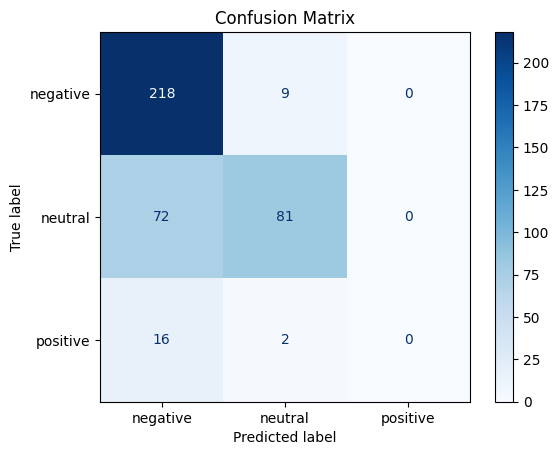

In [27]:
# Bagian 1: Membangun, melatih, dan menguji model
clf_nb = MultinomialNB()
model_nb = Pipeline([('vectorizer', tvec),
                     ('classifier', clf_nb)])

model_nb.fit(x_train, y_train)
hasil_nb = model_nb.predict(x_test)

# Bagian 2: Menampilkan Confusion Matrix
cm = confusion_matrix(y_test, hasil_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_nb.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [28]:
matrix = classification_report(y_test, hasil_nb)
print('classification report : \n', matrix)

classification report : 
               precision    recall  f1-score   support

    negative       0.71      0.96      0.82       227
     neutral       0.88      0.53      0.66       153
    positive       0.00      0.00      0.00        18

    accuracy                           0.75       398
   macro avg       0.53      0.50      0.49       398
weighted avg       0.74      0.75      0.72       398



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##  SVM

In [29]:
# Inisialisasi, training, dan prediksi menggunakan SVM
clf_svm = SVC(kernel='rbf')
model_svm = Pipeline([('vectorizer', tvec),
                      ('classifier', clf_svm)])

model_svm.fit(x_train, y_train)
hasil_svm = model_svm.predict(x_test)

In [30]:
matrix = classification_report(y_test, hasil_svm)
print('classification report : \n', matrix)

classification report : 
               precision    recall  f1-score   support

    negative       0.75      0.91      0.82       227
     neutral       0.82      0.66      0.73       153
    positive       0.00      0.00      0.00        18

    accuracy                           0.77       398
   macro avg       0.52      0.52      0.52       398
weighted avg       0.74      0.77      0.75       398



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#6. Testing

In [38]:
# Pastikan pandas sudah di-import sebagai pd
import pandas as pd

# 1. Load data testing dari file CSV
df_test = pd.read_csv("/content/drive/MyDrive/Dataset CSV/hasilStemmingTesting.csv")

# 2. Cleaning data
df_test = df_test.drop_duplicates(subset=['comment'])
df_test = df_test.dropna()

# 3. Prediksi pakai Naive Bayes
df_test['pred_nb'] = model_nb.predict(df_test['comment'])

# 4. Prediksi pakai SVM
df_test['pred_svm'] = model_svm.predict(df_test['comment'])

# 5. Tampilkan hasil
df_test.head(200)

,comment,pred_nb,pred_svm
0,sahkan ruu ampas aset berani dpr,negative,negative
1,bang densu ganti foliagenya banyak buntidak as...,negative,negative
2,kertas doang swasembada pangan nyata yang bawa...,negative,negative
3,ketua dpr serang runtuh runtuh pucuk akar dprnya,negative,negative
4,makanya biasa dengar jelas jangan asal ngamuk ...,negative,negative
...,...,...,...
198,langsung belok tajem,negative,negative
199,dpr sindikat korupsi kok mana mau atur ampas a...,negative,negative
200,bakal jadi,negative,negative
201,hadirin tuh ketua jangan krucil krucil nya und...,negative,negative
